### Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Image Path for Training

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/dataverse_files"
metadata_path = os.path.join(dataset_path, "HAM10000_metadata")
images_path = os.path.join(dataset_path, "HAM10000_images_combined_600x450")
mask_path = os.path.join(dataset_path, "HAM10000_segmentations_lesion")

In [ ]:
metadata = pd.read_csv(metadata_path)
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(images_path, f"{x}.jpg"))
metadata['mask_path'] = metadata['image_id'].apply(lambda x: os.path.join(mask_path, f"{x}_segmentation.png"))

### Preprocessing Data

In [ ]:
train, test = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train['dx'], random_state=42)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train['dx']), y=train['dx'])
class_weights_dict = {idx: weight for idx, weight in enumerate(class_weights)}

In [ ]:
# Label mapping
label_mapping = {label: idx for idx, label in enumerate(sorted(train['dx'].unique()))}
train['dx'] = train['dx'].map(label_mapping)
val['dx'] = val['dx'].map(label_mapping)
test['dx'] = test['dx'].map(label_mapping)

In [ ]:
# Preprocessing function
def preprocess_image_and_mask(image_path, mask_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Failed to load image: {image_path}")
    image = cv2.resize(image, target_size) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Failed to load mask: {mask_path}")
    mask = cv2.resize(mask, target_size) / 255.0

    masked_image = np.multiply(image, np.expand_dims(mask, axis=-1))
    return masked_image

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
def masked_image_generator(data, batch_size=32, target_size=(224, 224), augment=False):
    while True:
        for start in range(0, len(data), batch_size):
            batch_data = data.iloc[start:start+batch_size]
            batch_images, batch_labels = [], []

            for _, row in batch_data.iterrows():
                try:
                    masked_image = preprocess_image_and_mask(row['image_path'], row['mask_path'], target_size)
                    if augment:
                        masked_image = train_datagen.random_transform(masked_image)
                    batch_images.append(masked_image)
                    batch_labels.append(row['dx'])
                except FileNotFoundError:
                    continue  # Skip missing images

            yield np.array(batch_images), tf.keras.utils.to_categorical(batch_labels, num_classes=len(label_mapping))

In [ ]:
train_generator = masked_image_generator(train, batch_size=32, target_size=(224, 224), augment=True)
val_generator = masked_image_generator(val, batch_size=32, target_size=(224, 224), augment=False)

Streaming output truncated to the last 5000 lines.
Problematic Mask Path 5015: /content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000_segmentations_lesion/ISIC_0026639_segmentation.png
Problematic Mask Path 5016: /content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000_segmentations_lesion/ISIC_0031979_segmentation.png
Problematic Mask Path 5017: /content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000_segmentations_lesion/ISIC_0031680_segmentation.png
Problematic Mask Path 5018: /content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000_segmentations_lesion/ISIC_0026917_segmentation.png
Problematic Mask Path 5019: /content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000_segmentations_lesion/ISIC_0025207_segmentation.png
Problematic Mask Path 5020: /content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000_segmentations_lesion/ISIC_0029738_segmentation.png
Problematic Mask Path 5021: /content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000

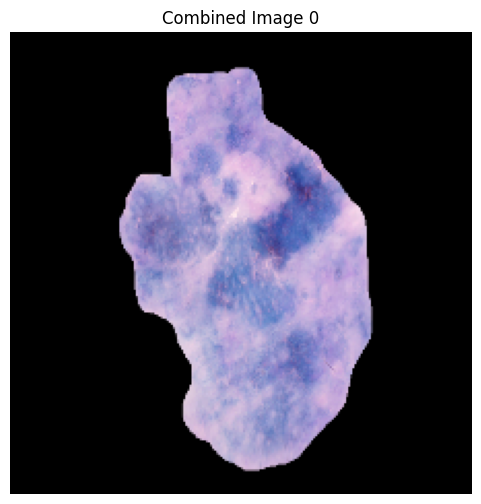

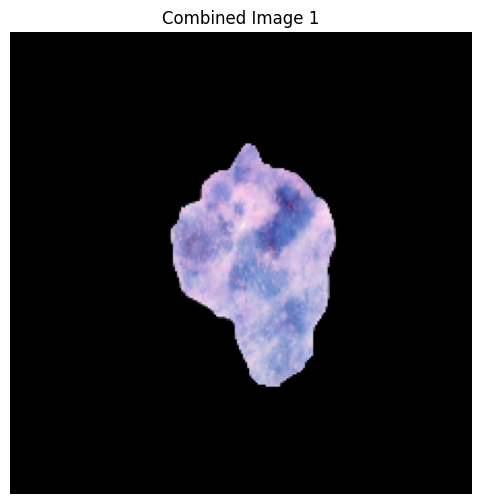

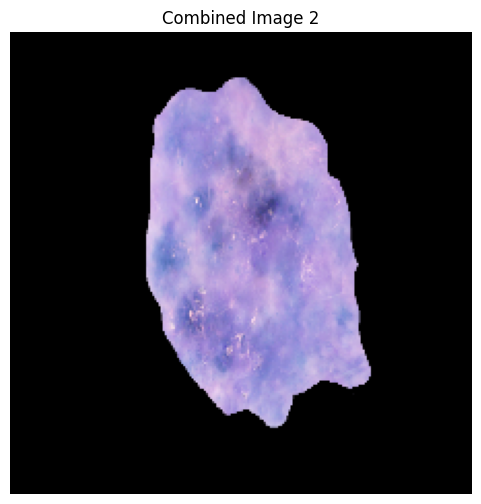

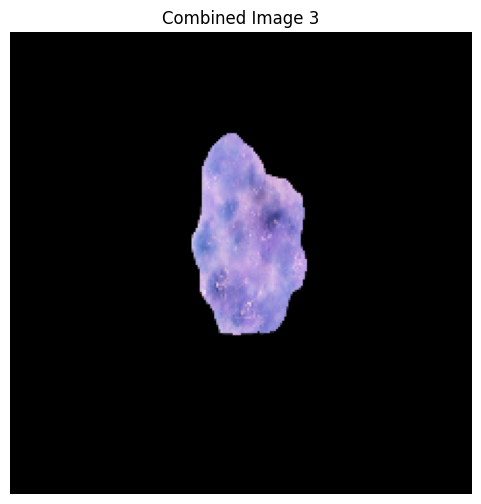

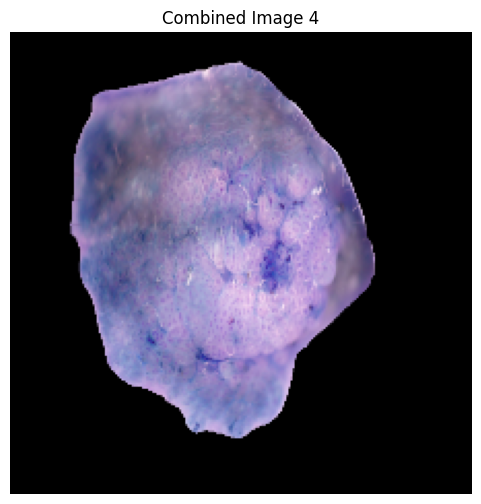

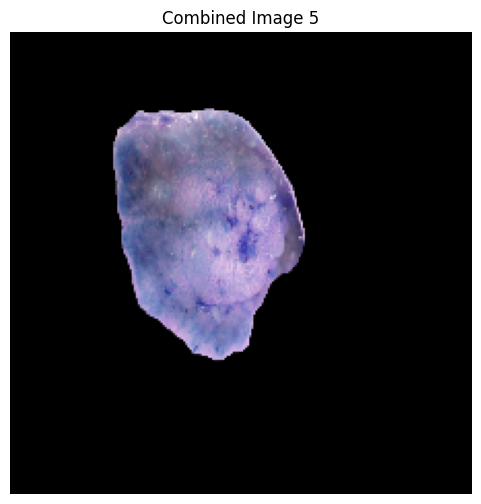

In [ ]:
import matplotlib.pyplot as plt
import os

mask_files = os.listdir("/content/drive/MyDrive/Colab Notebooks/dataverse_files/HAM10000_segmentations_lesion/")
print("Total Mask Files:", len(mask_files))
print("First 10 Mask Files:", mask_files[:10])  # Show a few files
for idx, row in metadata.iterrows():
    mask_path = row['mask_path']

    # Print paths where mask_path contains multiple filenames
    if "\\" in mask_path or "/" in mask_path:
        print(f"Problematic Mask Path {idx}: {mask_path}")

for idx, row in metadata.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']

    # Check if both files exist before processing
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        print(f"Missing file: {image_path} or {mask_path}")


    try:
        combined_image = preprocess_image_and_mask(image_path, mask_path)

        plt.figure(figsize=(6, 6))
        plt.imshow(combined_image, cmap='gray')  # Use cmap='gray' for better visibility
        plt.title(f"Combined Image {idx}")
        plt.axis("off")
        plt.show()

        if idx >= 5:  # Show only first 6 images
            break

    except Exception as e:
        print(f"Error processing {image_path} and {mask_path}: {e}")


### EfficientNetB0 Model

In [ ]:
# Load EfficientNetB0 as a feature extractor
efficientnet_base = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
feature_extractor = Model(inputs=efficientnet_base.input, outputs=efficientnet_base.output)

# Preprocess image
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    image = cv2.resize(image, target_size) / 255.0
    return np.expand_dims(image, axis=0)

# Extract features
def extract_features(data):
    features, labels = [], []
    for _, row in data.iterrows():
        try:
            image = preprocess_image(row['image_path'])
            feature_vector = feature_extractor.predict(image)[0]  # Extract features
            features.append(feature_vector)
            labels.append(row['dx'])  # Target class
        except FileNotFoundError:
            continue  # Skip missing images
    return np.array(features), np.array(labels)

# Load dataset
X, y = extract_features(metadata)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

joblib.dump((X_train, X_test, y_train, y_test), "/content/drive/MyDrive/Colab Notebooks/features.pkl")

print("Features extracted and saved successfully as 'features.pkl'!")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━

# XGBOOST

✅ Loaded Features - X_train: (8012, 1280), X_test: (2003, 1280)
✅ Labels converted to numerical encoding: {np.str_('akiec'): 0, np.str_('bcc'): 1, np.str_('bkl'): 2, np.str_('df'): 3, np.str_('mel'): 4, np.str_('nv'): 5, np.str_('vasc'): 6}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Accuracy: 0.7169

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.20      0.27        65
           1       0.43      0.23      0.30       103
           2       0.46      0.32      0.38       220
           3       1.00      0.04      0.08        23
           4       0.44      0.24      0.31       223
           5       0.78      0.95      0.85      1341
           6       1.00      0.04      0.07        28

    accuracy                           0.72      2003
   macro avg       0.65      0.29      0.32      2003
weighted avg       0.68      0.72      0.67      2003



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


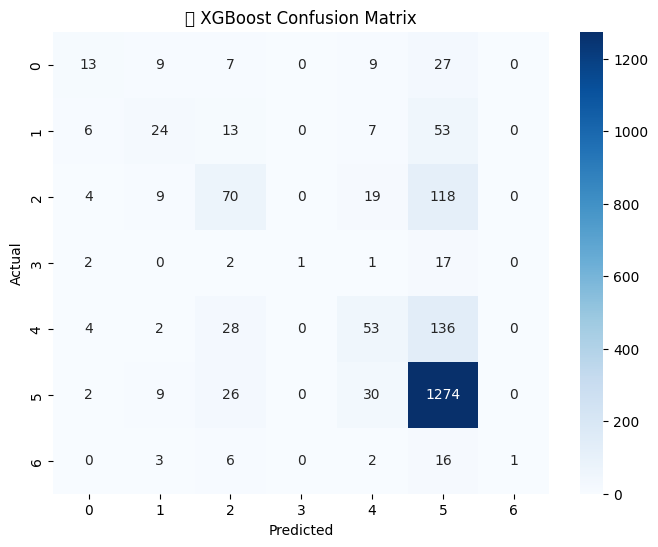

✅ XGBoost model and label mapping saved successfully!


In [ ]:
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Extracted Features
X_train, X_test, y_train, y_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/features.pkl")

print(f" Loaded Features - X_train: {X_train.shape}, X_test: {X_test.shape}")

# 2. Convert Labels to Numeric Encoding
label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_train)))}
y_train = [label_mapping[label] for label in y_train]
y_test = [label_mapping[label] for label in y_test]

print(" Labels converted to numerical encoding:", label_mapping)

# 3. Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=300,  # Number of trees
    max_depth=8,       # Tree depth
    learning_rate=0.01, # Lower learning rate for better generalization
    objective="multi:softmax", # Multiclass classification
    num_class=len(set(y_train)), # Number of classes
    use_label_encoder=False,
    eval_metric="mlogloss"
)

xgb_model.fit(X_train, y_train)

# 4. Predict on Test Set
y_pred = xgb_model.predict(X_test)

# 5. Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

# 6. Display Classification Report
class_report = classification_report(y_test, y_pred)
print("\n Classification Report:\n", class_report)

# 7. Confusion Matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

# 8. Save XGBoost Model
joblib.dump((xgb_model, label_mapping), "/content/drive/MyDrive/Colab Notebooks/xgboost.pkl")
print("XGBoost model and label mapping saved successfully!")


Top 5 Important Features:
Feature Index 474: Importance 1658.0
Feature Index 579: Importance 1370.0
Feature Index 1272: Importance 1131.0
Feature Index 1068: Importance 1103.0
Feature Index 612: Importance 998.0
[[-0.07037322 -0.09925424 -0.1336024  ... -0.19438341 -0.04991922
   0.05538441]
 [-0.06967578 -0.09909575 -0.1332151  ... -0.19493616 -0.04999989
   0.05426092]
 [-0.07067741 -0.0994975  -0.13377255 ... -0.19418761 -0.04984777
   0.05587546]
 [-0.0703925  -0.09937681 -0.13375315 ... -0.1942622  -0.04990492
   0.05568432]
 [-0.07049834 -0.09937409 -0.13368443 ... -0.19424745 -0.04986203
   0.05574267]]


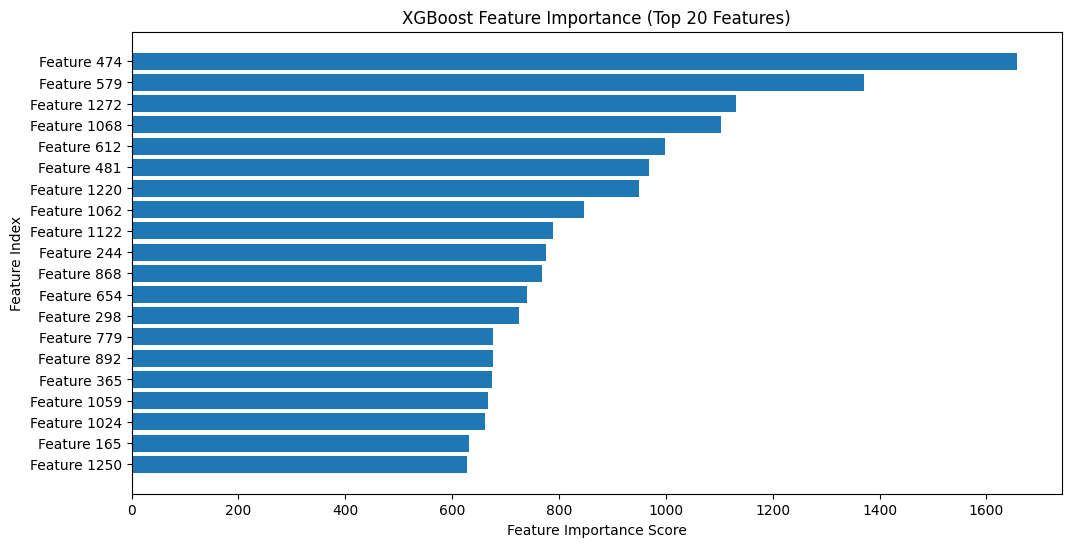

In [ ]:
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# load extracted features (from feature.pkl)
X_train, X_test, y_train, y_test = joblib.load("/content/drive/MyDrive/Colab Notebooks/features.pkl")

# Load your trained XGBoost model
xgb_model, label_mapping = joblib.load("/content/drive/MyDrive/Colab Notebooks/xgboost.pkl")

# Extract feature importances from the trained model
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")  # Can also use "gain" or "cover"

# Convert feature importance dictionary to sorted lists
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get feature names (default XGBoost uses f0, f1, f2...) and their importance values
feature_indices = [int(f[0][1:]) for f in sorted_features]  # Convert "f0" to 0, "f1" to 1, etc.
feature_scores = [f[1] for f in sorted_features]

# Print top 5 most important features
print("Top 5 Important Features:")
for i in range(5):
    print(f"Feature Index {feature_indices[i]}: Importance {feature_scores[i]}")

# Plot the importance of the top 20 features
plt.figure(figsize=(12, 6))
plt.barh([f"Feature {feature_indices[i]}" for i in range(20)], feature_scores[:20])  # Show top 20 features
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Index")
plt.title("XGBoost Feature Importance (Top 20 Features)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()
